# PCA Image compress

This project will be using unsupervised model to convert big images to grayscale and them compress them, loosing the minimun details as possible. 

**Problem to Solve:** You have a high-resolution grayscale image that takes up a lot of storage space. You need to compress the image by reducing the amount of data required to store it, while losing as little visual quality as possible.

As the grayscale image is just a matrix of pixel values, the PCA is a goo choice to underlying patters and by keeping only most important patters, it's possible to reconstruc a good approximation of the original image with much less data.

Even the **Exploratory data analysis will be a simple one** (only one image converted will be considered) and I don't expect much from the EDA itself, the other components of the project will show importante resources to be used on unsupervised machine learning scope.

## EDA

Loading the image, converting and create the matrix with pixel information

### Image selection and convertion to grayscale

Here, I choose one image took by myself that uses couple megabytes to be stored, let's start the import, show it and convert using python libraries.

Let's start with envrionment preparation

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.decomposition import PCA

Here is the image IMG_2119.JPG that I took myself. I'll user Pillow to manipulate the image. Here is the original one:

In [2]:
img_file = "IMG_2119.JPG"
#open the image
original_image=Image.open(img_file)

#let's print the size in MB
original_size_MB = os.path.getsize(img_file) / (1024 * 1024)
print("Original Image Size JPEG compressed (MB):", original_size_MB)

#convert it to grayscale
grayscale_image=original_image.convert("L")

original_array = np.array(original_image)
grayscale_array = np.array(grayscale_image)

print("Original image array:", original_array.shape)
print("Grayscale image array:", grayscale_array.shape)


#let's print the size in MB
original_size_MB = original_array.nbytes / (1024 * 1024)
print("Original Image Size (MB):", original_size_MB)

grayscale_size_MB = grayscale_array.nbytes / (1024 * 1024)
print("Grayscale Image Size (MB):", grayscale_size_MB)

Original Image Size JPEG compressed (MB): 3.30218505859375
Original image array: (3464, 4618, 3)
Grayscale image array: (3464, 4618)
Original Image Size (MB): 45.76707458496094
Grayscale Image Size (MB): 15.255691528320312


The color image is a 3D matrix (3 channels for RGB) and the grayscale is a simple 2D (height x width)
The JPEG itself does a great job compressing an image, the original image goes from ~46 mb from the array of pixel in 3 colors to ~3.3 mb in JPEG compresion.

Our objective here is not compare to JPG, but create our own model to compress images.

We can see the Original image array needs ~46 MB and the grayscale converted ~15 MB

### Let's show both images 

Original and converted

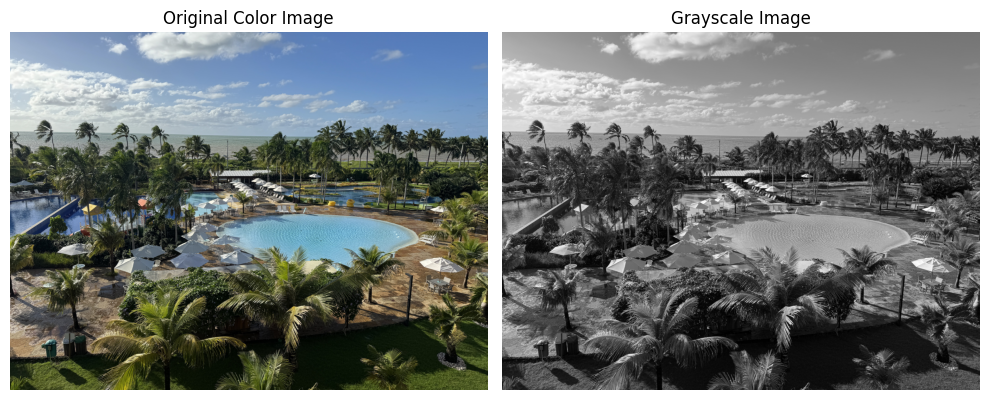

In [3]:
#plot two images side by side:
plt.figure(figsize=(10, 5))

# Subplot 1: Original Image
plt.subplot(1, 2, 1) # (1 row, 2 columns, 1st subplot)
plt.imshow(original_image)
plt.title("Original Color Image")
plt.axis('off') 

# Subplot 2: Grayscale Image
plt.subplot(1, 2, 2) # (1 row, 2 columns, 2nd subplot)
plt.imshow(grayscale_image, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')

    # Show the plots
plt.tight_layout()
plt.show()


Let's take a look at the cumulative explained variance. It should explains us why we can compress the image. It will show how much of the original image information (the variance) us captured by the principal component.

Also, to be prepared, as the PCA is sensitive to scaling, we need to normalize the pixel values to be between 0 and 1

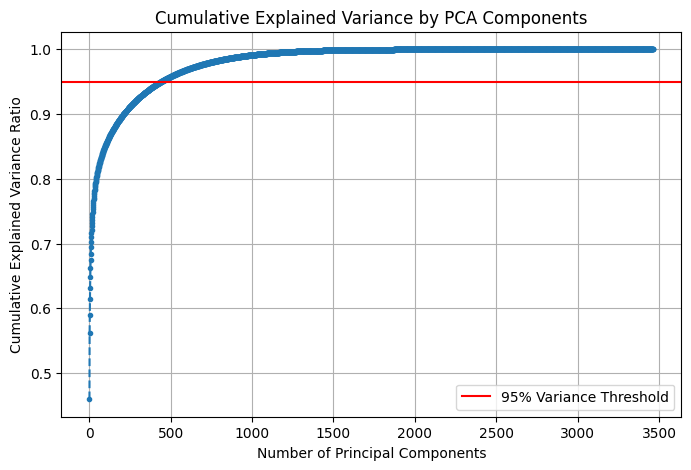

In [4]:
# scale the data
scaled_data = grayscale_array / 255.0

# Fit PCA with all possible components to check the variance
pca = PCA(n_components=min(scaled_data.shape))
pca.fit(scaled_data)

# Calculate the cumulative sum of explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='.', linestyle='--')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid(True)

plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance Threshold') #showing 95% variance
plt.legend()
plt.show()

And this is what we can conclude from the explained variance:

* As the curve shoots very fast, it show that a small number of principal capture a huge amount of the image's information, so the image has a high degree of data redundancy
* To get 95% variance threshold (it seems to be a good target for quality compression) we only need to keep ~500 principal componentes. As the image have ~3500 componentes, we can reduce it (3500/500) ~ 7x
* After 500-1000 principal components, the graph flat, so adding more components after this point will represent only fine visually not important details

## Model definition and transformation

As we saw let's keep the number of components to 0.95. Telling the PCA to keep components that explain 95% of the variance.

In [5]:
# Initialize the PCA model with 95% of variance
pca = PCA(n_components=0.95)

Now we need to fit the model and transform the data. The pca.fit_tranform function will learn the components from the data and reduce it dimensionality.

In [6]:
# fit the model and compress (tranform the data)
transformed_data = pca.fit_transform(scaled_data)

### Comparison and conclusions


First Let's compare the dimensions:

In [7]:
print(f"Original image dimensions: {scaled_data.shape}")
print(f"Compressed (transformed) data dimensions: {transformed_data.shape}")

Original image dimensions: (3464, 4618)
Compressed (transformed) data dimensions: (3464, 442)


Let's see the dimension difference on a plot

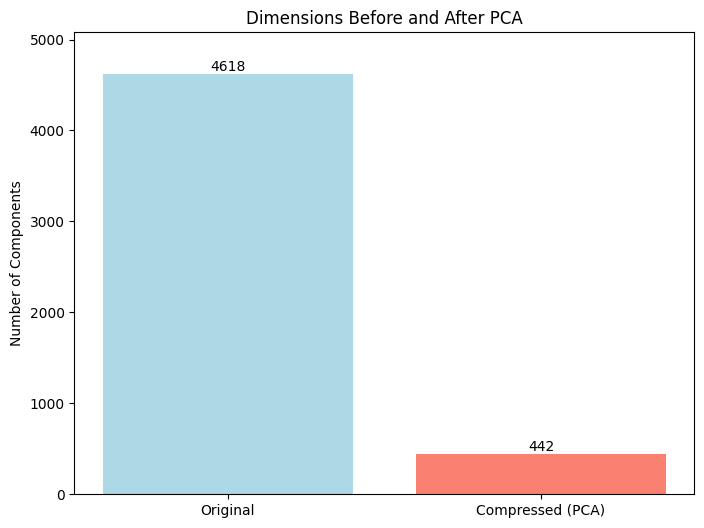

In [8]:
original_features = scaled_data.shape[1]
compressed_features = transformed_data.shape[1]
plt.figure(figsize=(8, 6))
categories = ['Original', 'Compressed (PCA)']
values = [original_features, compressed_features]

bars = plt.bar(categories, values, color=['lightblue', 'salmon'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

plt.title('Dimensions Before and After PCA')
plt.ylabel('Number of Components')
plt.ylim(0, original_features * 1.1)
plt.show()

This chart shows clearly the success of the model. There is a massive dimensionality reduction, the number of features to represent the image has dropped from 4618 to just 442 principal components. This lead us to a compress ration of (4618/442) of ~ 10.5x.

With this, the processing of the compressed data (with only 442 features) will be much faster and it will use much less memory and storage space if compared with the original 4618 with all 4618 features.

Then, let's take a look at the sizes

In [9]:
original_size_mb = grayscale_array.nbytes / (1024 * 1024)
print(f"Original Grayscale Image Size: {original_size_mb:.4f} MB")
transformed_data_size_b = transformed_data.nbytes

total_compressed_size_mb = (transformed_data_size_b + pca.components_.nbytes
) / (1024 * 1024)
print(f"True Compressed Data Size:    {total_compressed_size_mb:.4f} MB")


Original Grayscale Image Size: 15.2557 MB
True Compressed Data Size:    27.2541 MB


This is interesting, even it was mathematically reduced, it shows more storage is needed on the compressing array. This is because the data format. The compressed image is stored as float16 while the original grayscale array in uint8, so let's convert the compressed to see the reduction

In [10]:
original_size_mb = grayscale_array.nbytes / (1024 * 1024)
print(f"Original Grayscale Size (uint8): {original_size_mb:.2f} MB")

transformed_data_f16 = transformed_data.astype('float16')
pca_components_f16 = pca.components_.astype('float16')

compressed_size_f16_mb = (transformed_data_f16.nbytes + pca_components_f16.nbytes) / (1024 * 1024)
print(f"Compressed Size (float16): {compressed_size_f16_mb:.2f} MB")

final_ratio = original_size_mb / compressed_size_f16_mb
print(f"\nOptimized Compression Ratio: {final_ratio:.2f}x")

Original Grayscale Size (uint8): 15.26 MB
Compressed Size (float16): 6.81 MB

Optimized Compression Ratio: 2.24x


Ok, here we see a reduction of 2.24x, it's a good, confirming the compressing throught PCA is a viable form of reduciont storage size.

Then, lets look both images side by side.

To do it, we need to reconstruct the image... first bringing data from it's compressed form to the original dimension and then to rescale the image back to 0-255 pixel values

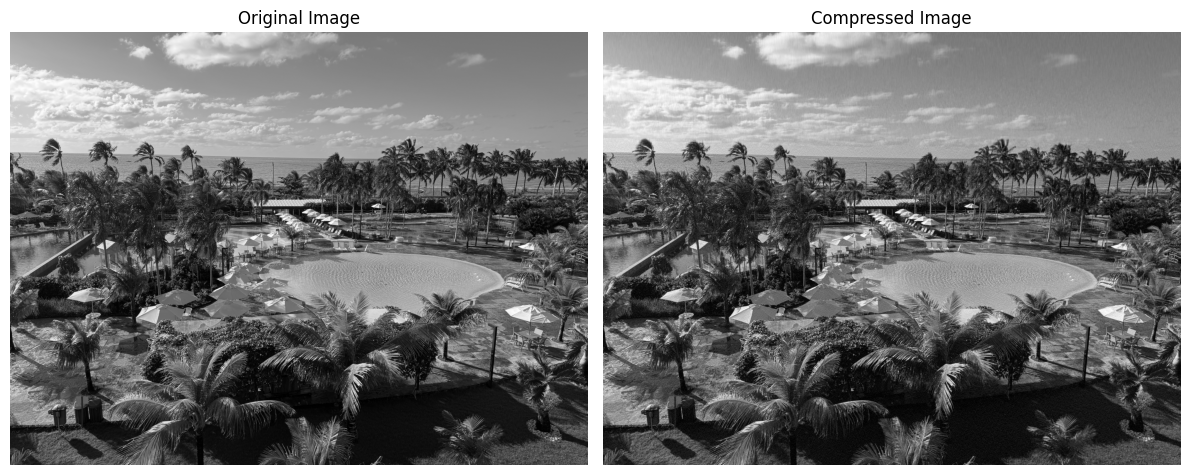

In [11]:
# first avert convertion to float16, we need to redo the inverse tranformation
reconstructed_data_f16 = pca.inverse_transform(transformed_data_f16)

# then rescale again
compressed_array_f16 = np.clip(reconstructed_data_f16 * 255, 0, 255).astype('uint8')


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(grayscale_array, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compressed_array_f16, cmap='gray')
plt.title("Compressed Image")
plt.axis('off')

plt.tight_layout()
plt.show()

so, The images as visually very similar, so, visually the model is a success. 

Let's also take a look also on the pixel intensity histogram. It show a histogram from 0 (black) to 255 (white). Comparing both we can see how PCA altered the image tonal range:

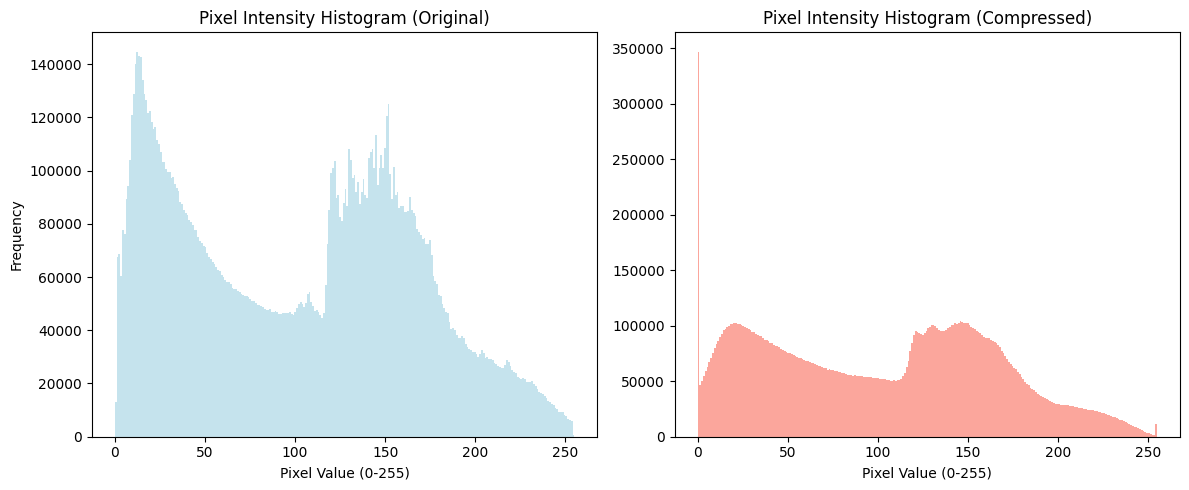

In [12]:
plt.figure(figsize=(12, 5))

# Original Histogram
plt.subplot(1, 2, 1)
plt.hist(grayscale_array.flatten(), bins=256, color='lightblue', alpha=0.7)
plt.title("Pixel Intensity Histogram (Original)")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")

# Compressed Histogram
plt.subplot(1, 2, 2)
plt.hist(compressed_array_f16.flatten(), bins=256, color='salmon', alpha=0.7)
plt.title("Pixel Intensity Histogram (Compressed)")
plt.xlabel("Pixel Value (0-255)")

plt.tight_layout()
plt.show()

As we can see, there is some generalization and smoothing effect, while the original histogram has many spikes ( representing fine variations in pixel intensity), the PCA transformed filteres the thigh frequency noide and generalized the pixel detail.

Also we can see the model is preserving the overall tonal structure and the shape of the histogram is preserved (peak and valleys are in the same general locations). This is a good sign of successful compression.

It's interesting to note the peak on 0 and on the far right, they are consqueunce of conversion from negative and > 255 out-of-bounds that was standarized by np.clip().

Let's calculate the difference, the reconstruction error to see what information was lost

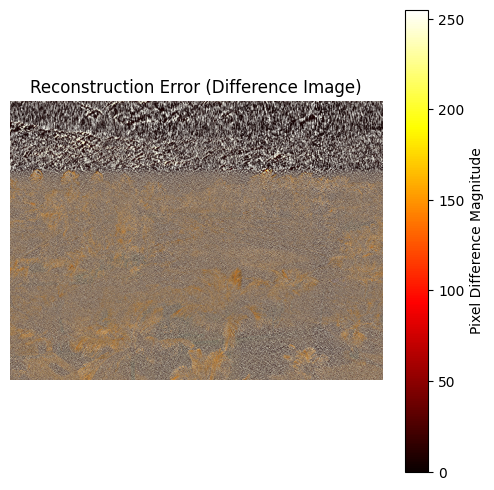

In [13]:
# Calculate the absolute difference between the two images
error_image = np.abs(grayscale_array - compressed_array_f16)

plt.figure(figsize=(6, 6))
plt.imshow(error_image, cmap='hot')
plt.title("Reconstruction Error (Difference Image)")
plt.colorbar(label="Pixel Difference Magnitude")
plt.axis('off')
plt.show()

The most important conclusion from the reconstruction error is that the information loss is not uniform and the error is not random noise. As the skyp is quite similar, the top section is much brighter (having a higher error) and because the image is different, it tells use this difference on the sky of the image.

In general, this plot proves that the compression successfully filtered couple fine details.

## Conclusion

The model proved highly effective at its primary goal of dimensionality reduction, successfully reducing the image's feature space from 4,618 to 442 components while retaining 95% of the original variance. This process preserved the image's overall tonal structure and key visual features, effectively smoothing out fine textures and high-frequency noise as confirmed by a reconstruction error analysis.

The analysis of the file size revealed the initial compressed representation was larger than the original due to data type overhead from converting 1-byte uint8 pixels to 8-byte float64 values. 

Then, to achieve a true compression, the resulting PCA matrices were optimized by converting them to a more efficient float16 data type. This final step successfully reduced the file size below that of the original, confirming that PCA is a viable method for compression, provided that data types are managed to offset the algorithm's storage requirements.

**This project was made using **Google Gemini 2.5 PRO** to answer specific questions related to the use of libraries and discuss the project